In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [ ]:
sdir = '/content/drive/MyDrive/XrayKneeOsteoarthritis'
image_size = (224, 224)
batch_size = 64
k_folds = 5

In [ ]:
filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths labels
0  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      2
1  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      2
2  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      2
3  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      2
4  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      2
labels
0    3798
2    2545
4    1790
1    1749
3    1281
Name: count, dtype: int64


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['labels'], random_state=42)

print(train_df['labels'].value_counts())
print(test_df['labels'].value_counts())

labels
0    3418
2    2290
4    1611
1    1574
3    1153
Name: count, dtype: int64
labels
0    380
2    255
4    179
1    175
3    128
Name: count, dtype: int64


In [ ]:
datagen = ImageDataGenerator(
  rescale=1.0/255,
  horizontal_flip = True,
  )

valid_generator = ImageDataGenerator(
    rescale = 1./255
)

test_generator = ImageDataGenerator(
    rescale = 1./255
)

test_gen = test_generator.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=image_size,
    batch_size=batch_size, class_mode='categorical', shuffle = True
)

print("Preprocessing dataset selesai.")

Found 1117 validated image filenames belonging to 5 classes.
Preprocessing dataset selesai.


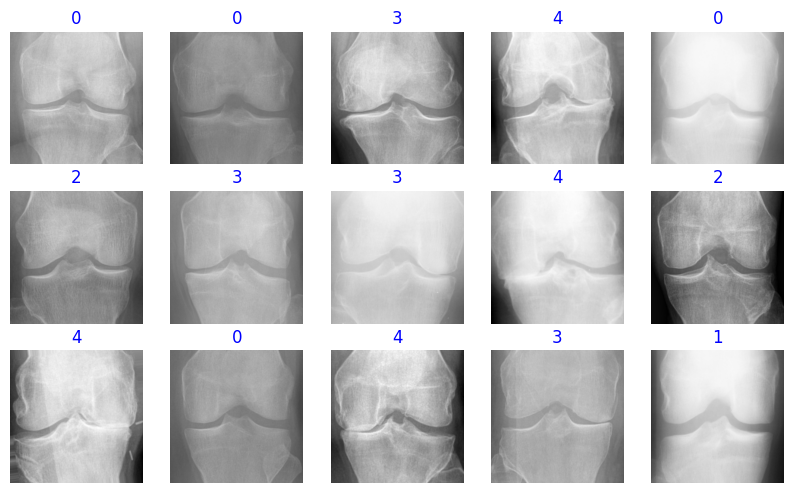

In [ ]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(10, 10))
    length=len(labels)
    if length<15:   #show maximum of 25 images
        r=length
    else:
        r=15
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

show_image_samples(test_gen)

In [ ]:
kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

def create_model():
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze semua layer kecuali 4 terakhir
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    x = base_model.output

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

fold_accuracies = []
histories = []
fold = 1

for train_index, val_index in kf.split(train_df, train_df['labels']):
    print(f'\nTraining Fold {fold}...')

    fold_train_df = train_df.iloc[train_index].reset_index(drop = True)
    fold_valid_df = train_df.iloc[val_index].reset_index(drop = True)

    classes = np.unique(fold_train_df['labels'])
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=fold_train_df['labels'])
    class_weight_dict = dict(zip(classes, class_weights))
    print(f"Class weights (Fold {fold}):", class_weight_dict)

    train_gen = datagen.flow_from_dataframe(
        fold_train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_gen = valid_generator.flow_from_dataframe(
        fold_valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    model = create_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[early_stopping, reduce_lr]
    )

    histories.append(history)

    scores = model.evaluate(val_gen, verbose=0)
    print(f"Fold {fold} - Loss: {scores[0]} - Accuracy: {scores[1]*100:.2f}%")

    fold_accuracies.append(scores[1] * 100)
    fold += 1

print('=================================')
print(f'Average accuracy over {k_folds} folds: {np.mean(fold_accuracies):.2f}% (+/- {np.std(fold_accuracies):.2f})')
print('=================================')



Training Fold 1...
Class weights (Fold 1): {'0': np.float64(0.5878566203365033), '1': np.float64(1.2765687053216839), '2': np.float64(0.877292576419214), '3': np.float64(1.7431670281995661), '4': np.float64(1.2468580294802172)}
Found 8036 validated image filenames belonging to 5 classes.
Found 2010 validated image filenames belonging to 5 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4680s 37s/step - accuracy: 0.3634 - loss: 1.5143 - val_accuracy: 0.2025 - val_loss: 1.8262 - learning_rate: 1.0000e-04
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 85s 672ms/step - accuracy: 0.5222 - loss: 1.0968 - val_accuracy: 0.5841 - val_loss: 0.9797 - learning_rate: 1.0000e-04
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 610ms/step - accuracy: 0.6066 - loss: 0.9332 - val_accuracy: 0.5468 - val_loss: 1.0110 - learning_rate: 1.0000e-04
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 609ms/step - accuracy: 0.6370 - loss: 0.8514 - val_accuracy: 0.6796 - val_loss: 0.7740 - learning_rate: 1.0000e-04
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 608ms/step - accuracy: 0.6559 - loss: 0.8151 - val_accuracy: 0.5806 - val_loss: 1.0831 - learning_rate: 1.0000e-04
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 606ms/step - accuracy: 0.6749 - loss: 0.7808 - val_accuracy: 0.5771 - val_loss: 1.1307 - learning_rate: 1.0000e-04
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 60

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 126s 940ms/step - accuracy: 0.3397 - loss: 1.5759 - val_accuracy: 0.3499 - val_loss: 1.5276 - learning_rate: 1.0000e-04
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 85s 674ms/step - accuracy: 0.5393 - loss: 1.0987 - val_accuracy: 0.5585 - val_loss: 1.0285 - learning_rate: 1.0000e-04
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 78s 615ms/step - accuracy: 0.5698 - loss: 0.9841 - val_accuracy: 0.6053 - val_loss: 0.9670 - learning_rate: 1.0000e-04
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 609ms/step - accuracy: 0.6403 - loss: 0.8572 - val_accuracy: 0.6257 - val_loss: 0.8804 - learning_rate: 1.0000e-04
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 76s 604ms/step - accuracy: 0.6663 - loss: 0.8116 - val_accuracy: 0.6088 - val_loss: 0.9730 - learning_rate: 1.0000e-04
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 606ms/step - accuracy: 0.6795 - loss: 0.7693 - val_accuracy: 0.6222 - val_loss: 0.9555 - learning_rate: 1.0000e-04
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 83s 6

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 92s 661ms/step - accuracy: 0.3139 - loss: 1.6171 - val_accuracy: 0.2807 - val_loss: 1.5087 - learning_rate: 1.0000e-04
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 132s 612ms/step - accuracy: 0.5024 - loss: 1.1675 - val_accuracy: 0.1613 - val_loss: 2.7728 - learning_rate: 1.0000e-04
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 612ms/step - accuracy: 0.5646 - loss: 1.0108 - val_accuracy: 0.6187 - val_loss: 0.9316 - learning_rate: 1.0000e-04
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 608ms/step - accuracy: 0.6112 - loss: 0.9056 - val_accuracy: 0.4778 - val_loss: 1.2270 - learning_rate: 1.0000e-04
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 85s 672ms/step - accuracy: 0.6592 - loss: 0.8279 - val_accuracy: 0.5450 - val_loss: 1.1596 - learning_rate: 1.0000e-04
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 78s 615ms/step - accuracy: 0.6690 - loss: 0.7847 - val_accuracy: 0.6784 - val_loss: 0.7893 - learning_rate: 2.0000e-05
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 6

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 92s 661ms/step - accuracy: 0.2969 - loss: 1.6763 - val_accuracy: 0.4306 - val_loss: 1.3070 - learning_rate: 1.0000e-04
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 85s 676ms/step - accuracy: 0.4939 - loss: 1.1710 - val_accuracy: 0.2295 - val_loss: 1.9599 - learning_rate: 1.0000e-04
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 135s 619ms/step - accuracy: 0.5693 - loss: 1.0034 - val_accuracy: 0.4291 - val_loss: 1.2893 - learning_rate: 1.0000e-04
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 613ms/step - accuracy: 0.6227 - loss: 0.8971 - val_accuracy: 0.4550 - val_loss: 1.1960 - learning_rate: 1.0000e-04
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 610ms/step - accuracy: 0.6383 - loss: 0.8528 - val_accuracy: 0.6775 - val_loss: 0.7532 - learning_rate: 1.0000e-04
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 606ms/step - accuracy: 0.6830 - loss: 0.7913 - val_accuracy: 0.5450 - val_loss: 1.6218 - learning_rate: 1.0000e-04
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 6

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 90s 650ms/step - accuracy: 0.3490 - loss: 1.5457 - val_accuracy: 0.2195 - val_loss: 2.1985 - learning_rate: 1.0000e-04
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 612ms/step - accuracy: 0.5510 - loss: 1.0696 - val_accuracy: 0.4316 - val_loss: 1.3136 - learning_rate: 1.0000e-04
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 610ms/step - accuracy: 0.6152 - loss: 0.9100 - val_accuracy: 0.6038 - val_loss: 0.9629 - learning_rate: 1.0000e-04
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 608ms/step - accuracy: 0.6590 - loss: 0.8360 - val_accuracy: 0.5829 - val_loss: 1.3281 - learning_rate: 1.0000e-04
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 76s 602ms/step - accuracy: 0.6821 - loss: 0.7731 - val_accuracy: 0.6401 - val_loss: 0.8288 - learning_rate: 1.0000e-04
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 76s 604ms/step - accuracy: 0.6896 - loss: 0.7324 - val_accuracy: 0.5401 - val_loss: 1.0787 - learning_rate: 1.0000e-04
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 60

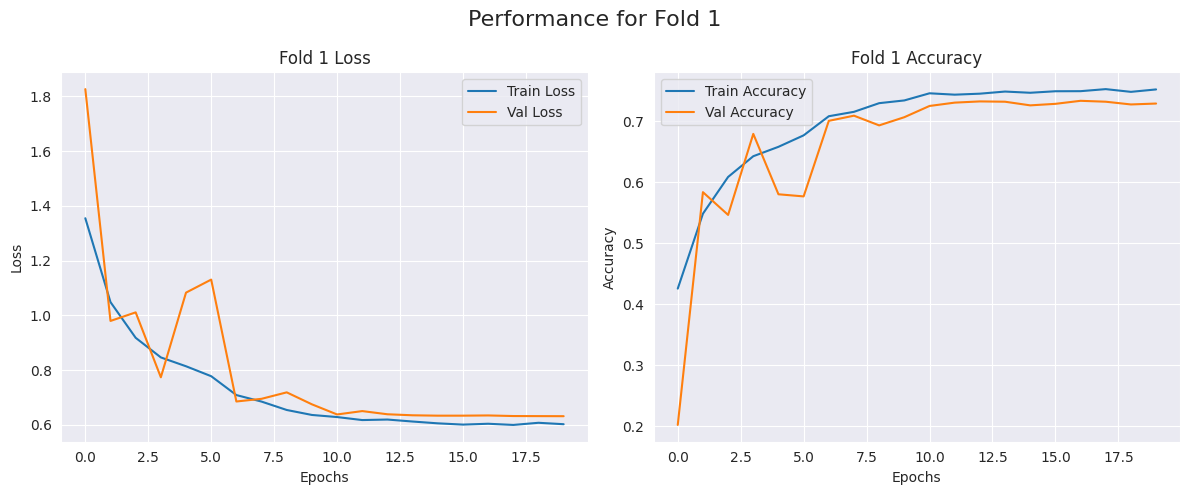

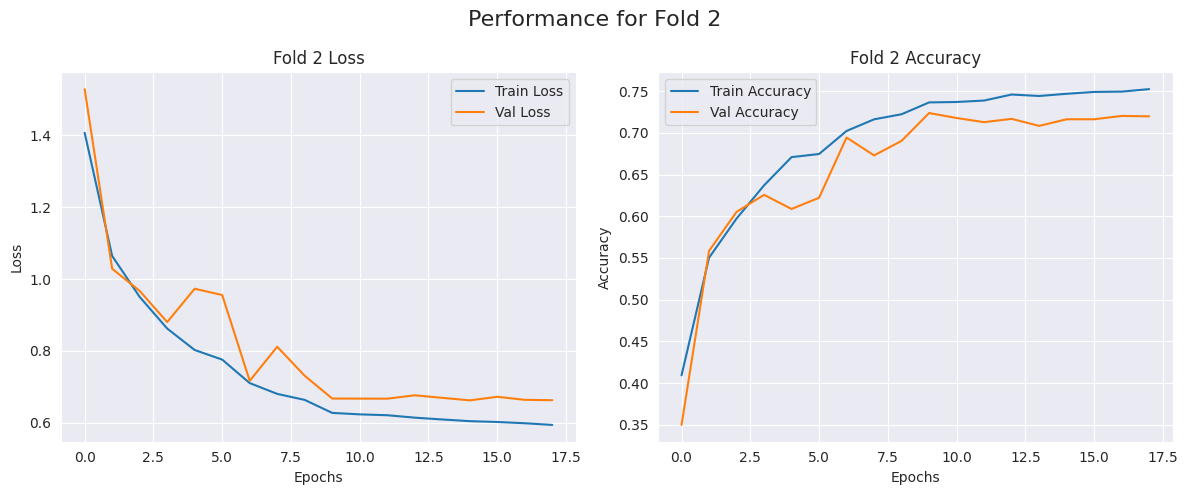

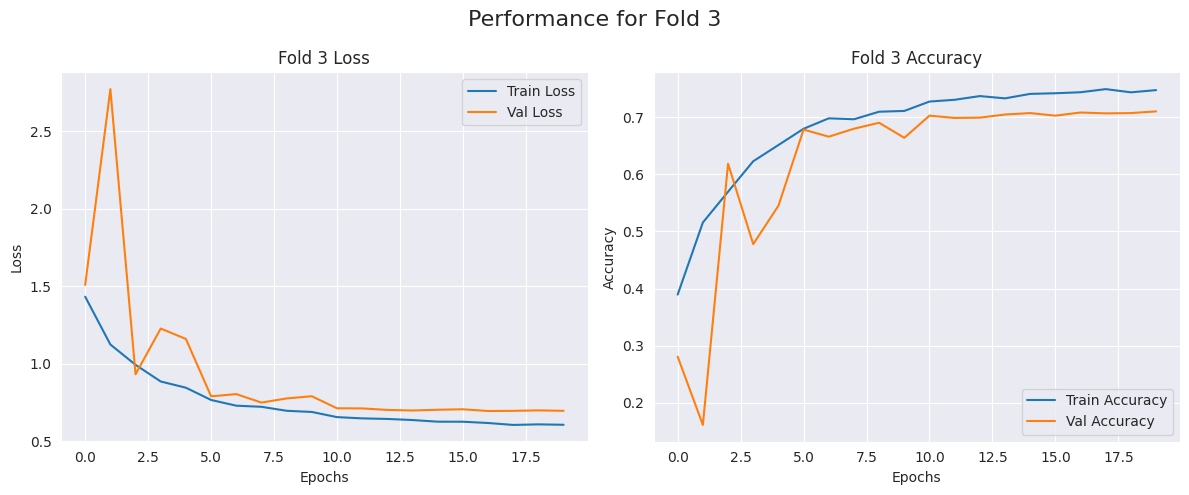

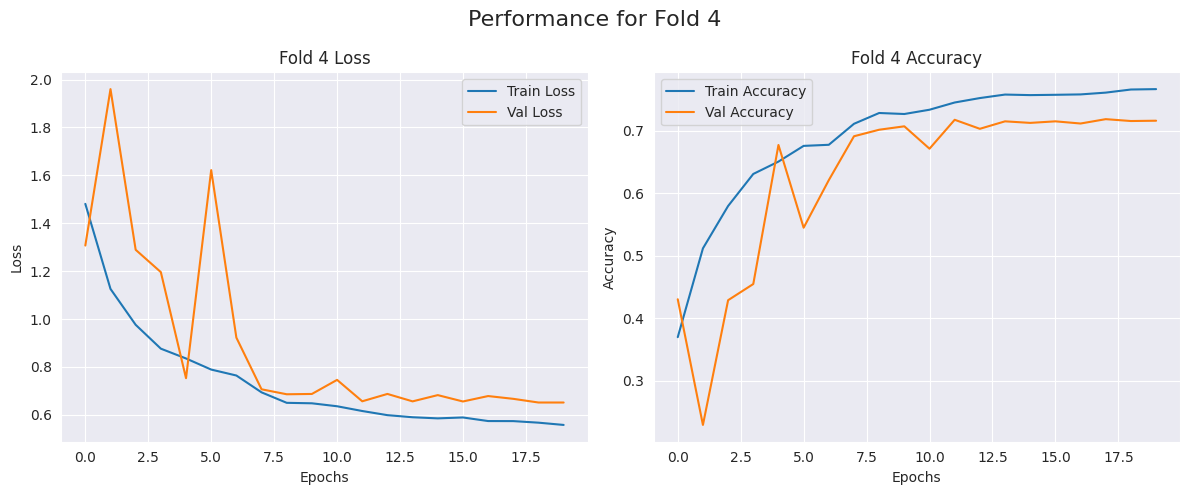

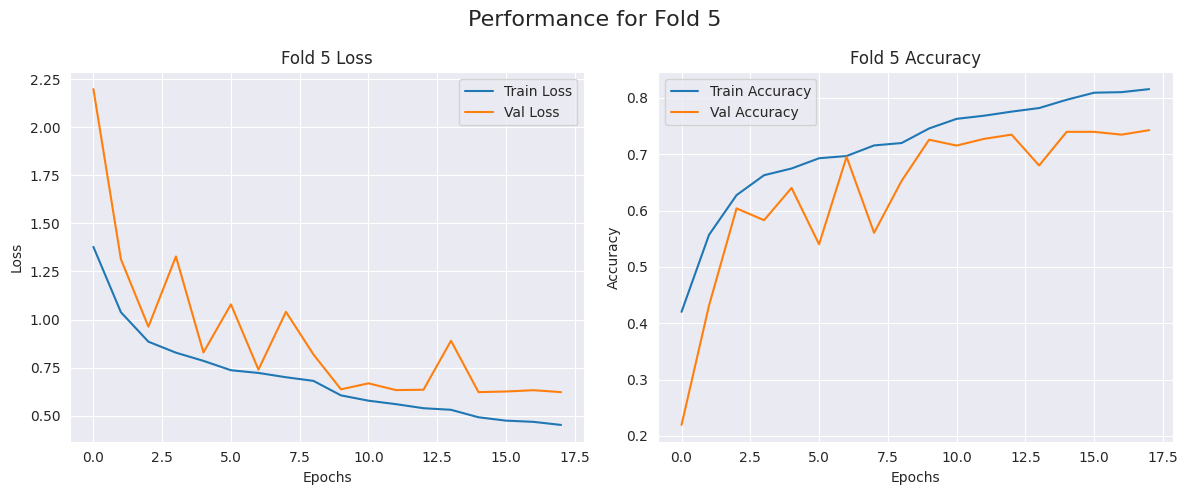

Semua plot selesai!


In [ ]:
for i, history in enumerate(histories, start=1):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(f'Performance for Fold {i}', fontsize=16)
    plt.tight_layout()
    plt.show()  # tampilkan plot fold i

print("Semua plot selesai!")

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 211ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


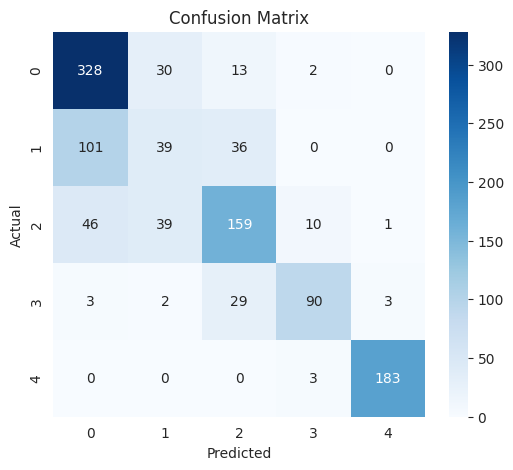

              precision    recall  f1-score   support

           0       0.69      0.88      0.77       373
           1       0.35      0.22      0.27       176
           2       0.67      0.62      0.65       255
           3       0.86      0.71      0.78       127
           4       0.98      0.98      0.98       186

    accuracy                           0.72      1117
   macro avg       0.71      0.68      0.69      1117
weighted avg       0.70      0.72      0.70      1117



In [ ]:
y_true = []
y_pred = []
class_labels = list(test_gen.class_indices.keys())

for _ in range(len(test_gen)):
    x_batch, y_batch = next(test_gen)
    y_true.extend(np.argmax(y_batch, axis=1))  # Label asli
    y_pred.extend(np.argmax(model.predict(x_batch), axis=1))  # Prediksi model

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
model.save('/content/drive/MyDrive/my_model.h5')